# Principal Component Analysis Part 2

In this notebook, we will continue to discuss Principal Component Analysis to examine axes of variance in data. Here, we will use a multi-dimensional dataset to find co-variablity in data that is difficult to visualize in all at once.

**Learning Objectives**

1. Conduct a PCA on a multi-dimensional data set
2. Create and assess a factor loading matrix
3. Identify covariability in data using the results of PCA

**Import modules**

Begin by importing the modules to be used in this notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
from scipy import linalg
import pandas as pd

In [3]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Motivation
In the previous notebook, we examined a PCA example using wind data - a 2 dimensional dataset we could visualize on a simple plot. In this notebook, we're going to expand on this analysis to including more components of weather beyond wind speed including temperature, precipitation, pressure, and cloud cover.

## An Example Data Set: Weather in San José

In this notebook, we are going to investigate patterns in of weather variability in San José. This data is from the European Centre for Medium Range Weather Forecasting - the default weather model shown on the popular [Windy](www.windy.com) weather visualization map.

First, let's read in this data to a `pandas` dataframe:

In [4]:
df = pd.read_csv('San Jose Weather 2016-2025.csv', skiprows=[1])

Let's take a look at some of the fields:

In [5]:
df.head()

,Date,Temperature,Precipitation,Wind Speed,Cloud Cover,Pressure
0,2016/01/01,272.59,0.000000e+00,1.21,0.02,96407.75
1,2016/01/02,276.66,0.000000e+00,0.21,0.89,96366.06
2,2016/01/03,278.74,0.000000e+00,2.26,0.97,95878.94
3,2016/01/04,279.57,9.537000e-07,1.66,0.97,95334.62
4,2016/01/05,281.87,2.075195e-03,3.68,0.91,94981.38


In our dataframe, each of these values looks useable (i.e. the data types are interpreted correctly) but let's double check:

In [6]:
df.dtypes

Date              object
Temperature      float64
Precipitation    float64
Wind Speed       float64
Cloud Cover      float64
Pressure         float64
dtype: object

As we can see, all of the data fields are floats but the Date field has an "object" type. Let's make this an actual data time object:

In [7]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')

In [8]:
df.dtypes

Date             datetime64[ns]
Temperature             float64
Precipitation           float64
Wind Speed              float64
Cloud Cover             float64
Pressure                float64
dtype: object

Finally, for our plots below, let's also grab the second row of the data frame:

In [9]:
df_for_units = pd.read_csv('San Jose Weather 2016-2025.csv', header=0)
units = df_for_units.iloc[0].tolist()
print(units)

['--', 'K', 'mm', 'm/s', '%', 'Pa']


Ok, let's have a look at the data we read in:

['Temperature', 'Precipitation', 'Wind Speed', 'Cloud Cover', 'Pressure']


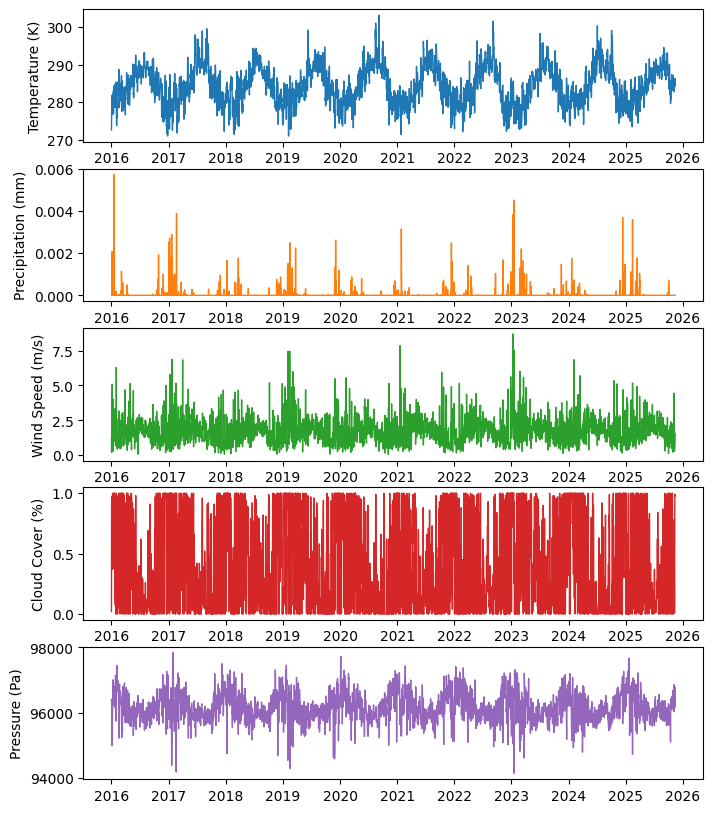

In [10]:
# make a list with the variable names
variable_names = list(df.keys())[1:]
print(variable_names)

# plot the time series for each of them
fig = plt.figure(figsize=(8, 10))
for v, variable_name in enumerate(variable_names):
    plt.subplot(5, 1, v+1)
    plt.plot(df['Date'], df[variable_name], linewidth=1, color=colors[v])
    plt.ylabel(f'{variable_name} ({units[v+1]})')
plt.show()

In the example data, we might be interested in the following question: *what are the general patterns of weather in San José and how these weather parameters inter-related*? 

If we phrase this question as a data science question, we might alternatively ask: **what are the axes of highest variance in this data set and how do the data co-vary?**

### The PCA Recipe

As we saw in our previous notebook, the steps for PCA are as follows:
- Step 0: Formulate a data matrix $X$ which is size $(N, M)$
- Step 1: Compute the Covariance Matrix of $X$
- Step 2: Compute Eigenvalues and Eigenvectors

Let's see work through this recipe for our new data:

#### Step 0: The Data Matrix
First, we create the data matrix:

In [11]:
# create the data matrix
X = np.column_stack([df['Temperature'], df['Precipitation'], df['Wind Speed'], df['Cloud Cover'], df['Pressure']])

In this example, we'll normalize each data using $z$-scores:

In [12]:
for i in range(np.shape(X)[1]):
    vals = X[:, i]
    vals = (vals - np.mean(vals)) / np.std(vals)
    X[:, i] = vals

This will be a suitable approach for assessing some patterns in this data for this example. In practice, however, you may want to consider the following in your normalization procedure:
- Almost all of these variables have a seasonal cycle
- Precipitation has mostly zero values (for San José)
- Cloud cover has values in the range 0-1
  
Addressing these considerations could lead to better results, depending on what question you are interested in answering with your data.

#### Step 1: The Covariance Matrix
Up next, we will compute the covariance matrix $C$. As before, we can use numpy's `cov` function to compute the covariance matrix:

In [13]:
# enter code for the covariance matrix here
C = np.cov(X, rowvar=False)

#### Step 2: Compute Eigenvalues and Eigenvectors
In the final step of the PCA procedure, we compute the eigenvalues ($\lambda_i$'s) and eigenvectors ($\textbf{v}_i$'s) of the covariance matrix:

In [14]:
# enter code to compute the values and vectors 
values, vectors = linalg.eig(C)

As before, let's ensure our values are real and that they are sorted:

In [15]:
# sanity check that the values are real
values = np.real(values)

# sort the values and vectors
sorted_indices = np.argsort(values)[::-1]
values = values[sorted_indices]
vectors = vectors[:, sorted_indices]

### Interpreting PCA Results

In the steps above, we recovered two important pieces of information. The first piece is our eigenvectors - as mentioned above, these tell us about the dominant axes of variablity in in our data. Be default, these are scaled to have length 1. The eigenvalues give us a quantification of the variance along the axes identified by the eigenvectors - in effect, they give us the magnitude of our eigenvectors relative to the others. We can quantify this information for our two vectors below.

Let's see how much variance each of these values explains in our data:

In [16]:
# compute the variance explained
variance_explained = 100 * values / np.sum(values)

print(f'The first component explains {variance_explained[0]:.2f}% of the variance.')
print(f'The second component explains {variance_explained[1]:.2f}% of the variance.')

The first component explains 34.86% of the variance.
The second component explains 28.40% of the variance.


### Factor Loading Matrix

Up next, we'll examine the factor loading matrix - our collection of eigenvectors multiplied by the square root of the eigenvalues. We can compute this succinctly as follows:
$$
A = V \sqrt{\Lambda}
$$

Here $V$ is a matrix with all of our eigenvectors as columns and $\Lambda$ is a matrix with the eigenvalus on the diagonal. Let's compute that here:

In [17]:
# the factor loading matrix
A = vectors @ np.sqrt(np.diag(values))

# print the shape
A

array([[-0.47328098,  0.67685033, -0.4240389 , -0.12447133, -0.35050562],
       [-0.53354746, -0.5754679 ,  0.03610651, -0.61807104, -0.03355388],
       [-0.72810421, -0.2051664 ,  0.47459274,  0.36052914, -0.26986853],
       [-0.07595786, -0.73243098, -0.59762346,  0.30807795, -0.07737562],
       [ 0.83614937, -0.22928375,  0.14200066, -0.12291634, -0.46183128]])

Since our eigenvectors quantify the variance of each variable along our new transofrmed axes, we can assess the values of our variables on the first two principal components to see how they co-vary. Let's plot those values here:

Text(0, 0.5, 'Principal Component 2')

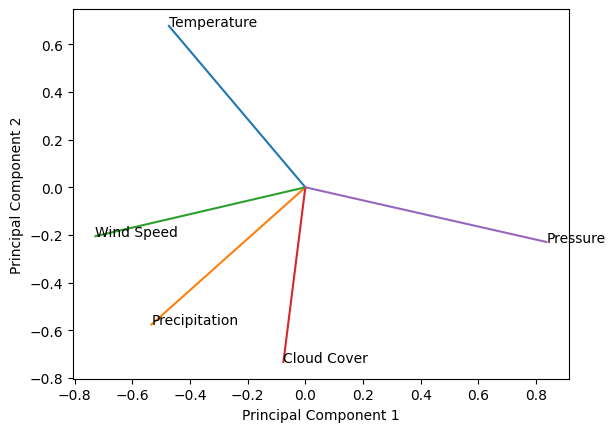

In [18]:
for i, variable_name in enumerate(variable_names):
    plt.plot([0, A[i, 0]], [0, A[i, 1]], '-', color=colors[i])
    plt.text(A[i, 0], A[i, 1], variable_name)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

Again, these values gives us a sense for how each of the variables in our design matrix co-vary. Let's first consider the first principal component - we can see in this component that wind speed and pressure have strongly different values along this axis. Let's plot them below for one year:

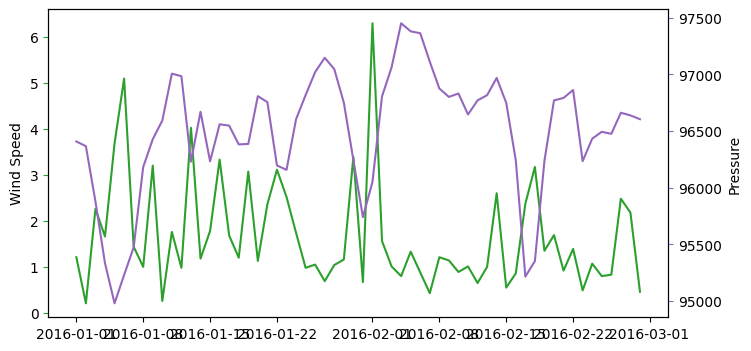

In [23]:
n_days = 60

fig = plt.figure(figsize=(8, 4))
ax = plt.gca()

plt.plot(df['Date'][:n_days], df['Wind Speed'][:n_days], color=colors[2])
ax.tick_params(axis='y', color=colors[2])
ax.set_ylabel('Wind Speed')

ax2 = ax.twinx()    
plt.plot(df['Date'][:n_days], df['Pressure'][:n_days], color=colors[4])
ax2.tick_params(axis='y', color=colors[4])
ax2.set_ylabel('Pressure')

plt.show()

In this example, we can see that wind speed and pressure behave roughly oppositely - when pressure is high, wind speed is low; and vice versa. This is expected because lower pressure is associated with storms that often bring wind.

Let's check out the relationship between temperature and cloud cover, which have opposite signs along PC2:

Text(0, 0.5, 'Cloud Cover')

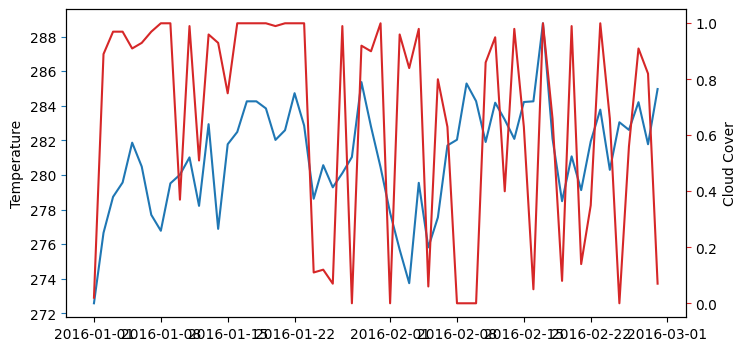

In [25]:
n_days = 60

fig = plt.figure(figsize=(8, 4))
ax = plt.gca()

plt.plot(df['Date'][:n_days], df['Temperature'][:n_days], color=colors[0])
ax.tick_params(axis='y', color=colors[0])
ax.set_ylabel('Temperature')

ax2 = ax.twinx()    
plt.plot(df['Date'][:n_days], df['Cloud Cover'][:n_days], color=colors[3])
ax2.tick_params(axis='y', color=colors[3])
ax2.set_ylabel('Cloud Cover')

Here again, we see that one of these variables is generally high when the other is low, and vice versa.

### Amplitude of the Principal Components
The amplitude of the principal components allow us to investigate the variability along our identified axes of variablity. As we saw in the previous notebook, this amplitude matrix is computed as

$$
\tau = XV
$$

where $V$ is the eigenvector matrix. The principal components are the columns of this matrix and correspond to our data projected onto each of the axes of variance. Let's see what this looks like for our timeseries:

In [26]:
# compute tau
tau = np.dot(X, vectors)

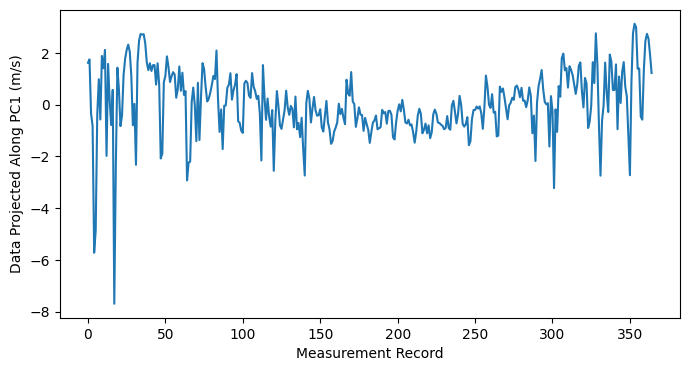

In [27]:
plt.figure(figsize=(8,4))
plt.plot(tau[:365, 0])
plt.ylabel('Data Projected Along PC1 (m/s)')
plt.xlabel('Measurement Record')
plt.show()

Here, we can see that the magnitude along PC1 is much higher in winter than it is in summer - and in winter, we have much bigger swings between high pressure, low-wind days and low pressure, high-wind days. 

Let's see the other dimension:

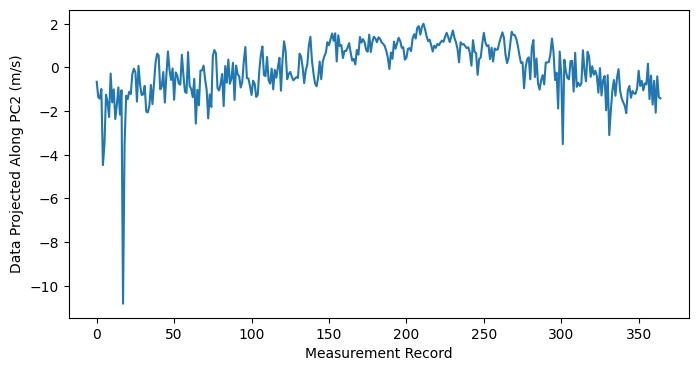

In [29]:
plt.figure(figsize=(8,4))
plt.plot(tau[:365, 1])
plt.ylabel('Data Projected Along PC2 (m/s)')
plt.xlabel('Measurement Record')
plt.show()

As we can see, summer time is associated with a positive PC2 - the axis that correponds to higher temperature and lower cloud cover.

**Key Takeaways**

1. In higher-dimensional datasets, a PCA can help you identify how your data co-varies
2. PCA identifies general patterns in the data